# Issue -  Pull Link prediction with Heterogeneous GraphSAGE (HinSAGE)

## Preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH = "/content/drive/MyDrive/TOM"

import os.path

In [4]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 5.3 MB/s 
     |████████████████████████████████| 482 kB 53.7 MB/s 
     |████████████████████████████████| 41 kB 680 kB/s 


In [5]:
#!pip install PyGithub -q
#!pip install tomotopy -q
#!pip install pyldavis -q
#!pip install wordcloud -q
#!pip install -U sentence-transformers -q
#!pip install fasttext -q
!pip install gensim -q

In [6]:
import pandas as pd
import sklearn 
import numpy as np
#import tomotopy as tp
#print(tp.isa) # prints 'avx2', 'avx', 'sse2' or 'none' # processing instruction set

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from tqdm import tqdm
from collections import Counter
#import pyLDAvis
#from wordcloud import WordCloud
import gensim
import os.path
#from sentence_transformers import SentenceTransformer
import urllib
import pickle
import gensim
#import fasttext

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [7]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [8]:
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

Specify the minibatch size (number of repo-issue links per minibatch) and the number of epochs for training the ML model:

In [9]:
batch_size = 200
epochs = 20
# Use 70% of edges for training, the rest for testing:
train_size = 0.7
test_size = 0.3

## Load the Issue Topic model

In [10]:
!pip install tomotopy -q

import tomotopy as tp

     |████████████████████████████████| 16.3 MB 3.0 MB/s 


In [11]:
lda_model_path = os.path.join(PATH, "models", "commits_lda.bin")
lda_model_path2 = os.path.join(PATH, "models", "issues_lda.bin")

lda_model_path, lda_model_path2

('/content/drive/MyDrive/TOM/models/commits_lda.bin',
 '/content/drive/MyDrive/TOM/models/issues_lda.bin')

In [12]:
lda = tp.LDAModel.load(lda_model_path)
lda2 = tp.LDAModel.load(lda_model_path2)

In [13]:
#unseen_doc = lda.make_doc(['i', 'died'])
#predicted_topic, ll = lda.infer(unseen_doc)
#
#predicted_topic, ll

In [14]:
#np.argmax(predicted_topic)

In [15]:
lda.get_topic_words(17)

[('thank', 0.05494626238942146),
 ('transact', 0.05494626238942146),
 ('properti', 0.05494626238942146),
 ('object', 0.05494626238942146),
 ('error', 0.05494626238942146),
 ('paket', 0.043978944420814514),
 ('lib', 0.033011626452207565),
 ('local', 0.033011626452207565),
 ('attach', 0.022044308483600616),
 ('avoid', 0.022044308483600616)]

In [16]:
lda.summary()

<Basic Info>
| LDAModel (current version: 0.12.2)
| 501 docs, 2771 words
| Total Vocabs: 1223, Used Vocabs: 1218
| Entropy of words: 6.65964
| Entropy of term-weighted words: 6.65964
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 1000, Burn-in steps: 10
| Optimization Interval: 10
| Log-likelihood per word: -7.94577
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 32 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 0 (random seed)
| trained in version 0.12.2
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.06084735 0.031599

In [17]:
lda2.summary()

<Basic Info>
| LDAModel (current version: 0.12.2)
| 11388 docs, 496509 words
| Total Vocabs: 32951, Used Vocabs: 3685
| Entropy of words: 7.18779
| Entropy of term-weighted words: 7.18779
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 2000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -6.47679
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 10 (minimum collection frequency of words)
| min_df: 10 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 64 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 0 (random seed)
| trained in version 0.12.2
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.02424421 0.

Load the mapping issue - commit

In [18]:
mapping_path = os.path.join(PATH, "models", "issue_commit.csv")
mapping_path2 = os.path.join(PATH, "models", "repo_issue.csv")

mapping = pd.read_csv(mapping_path).rename(columns = {"issue":"commit"}) #, index_col = 'issue')
#mapping[mapping.loc[mapping.index.drop_duplicates()].index.duplicated()]
mapping2 = pd.read_csv(mapping_path2,index_col=0)

mapping

,commit,topic
0,0,5
1,1,26
2,2,8
3,3,28
4,4,25
...,...,...
496,496,9
497,497,12
498,498,2
499,499,27


In [19]:
# mapping = mapping.loc[mapping.issue.drop_duplicates().index]
mapping = mapping.set_index('commit')

In [20]:
mapping

,topic
commit,
0,5
1,26
2,8
3,28
4,25
...,...
496,9
497,12
498,2


In [21]:
mapping2

,topic
issue,
4,42
5,42
7,56
8,18
12,21
...,...
46956,60
46957,60
46959,48


## Load the dataset

Load the repo measurements 

In [22]:
# issues.url.iloc[0]

In [23]:
# mapping2.loc[selected_issues.index]

In [24]:
# lda2.summary()
lda2.docs[0]

<tomotopy.Document with words="faucet working kylin testnet trying faucet apis described respond success message transaction id check any kylin block explorer account token never actually send also create account already exist kylin make think this faucet connected real kylin testnet">

In [25]:
# metrics_path = os.path.join(PATH, "metrics", "metrics.csv")
bugissues_path = os.path.join(PATH, "issues", "bugissues.csv")
fixingcommits_path = os.path.join(PATH, "commits", "fixingcommits.csv")




# metrics_path = os.path.join(PATH, "metrics", "metrics.csv")
issues_path = os.path.join(PATH, "issues", "issues.csv")

In [26]:
# metrics_path = os.path.join(metrics_path)
# 
# metrics = pd.read_csv(metrics_path, index_col = "repo_fullname").iloc[:, :-1]
# 
# metrics

Load the issues data

In [27]:
#issues_path = os.path.join(PATH, "tom_issues_infos_202205121552.csv")
#issues_path = os.path.join(issues_path)

issues = pd.read_csv(issues_path) 
bugissues = pd.read_csv(bugissues_path, index_col = 0)
fixingcommits = pd.read_csv(fixingcommits_path, index_col = 0)

fixingcommits.head()

fixingcommits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, https://api.github.com/repos/web3p/ethereum-tx/commits/83d9305ba4782bc310b4b4e6f86024e27198d8e2 to https://api.github.com/repos/meshtastic/Meshtastic-python/commits/7457d3340cc3f48f24cd8e1e079948261aa02adc
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   issue_url  501 non-null    object
 1   message    501 non-null    object
dtypes: object(2)
memory usage: 11.7+ KB


In [28]:
# issues.loc[bugissues.index].drop_duplicates()
# issues.loc[bugissues.index].drop_duplicates()

In [29]:
fixingcommits # = fixingcommits.loc[mapping.index]

,issue_url,message
commit_url,,
https://api.github.com/repos/web3p/ethereum-tx/commits/83d9305ba4782bc310b4b4e6f86024e27198d8e2,https://api.github.com/repos/web3p/ethereum-tx...,Fix #41: hash didn't return transaction hash
https://api.github.com/repos/web3p/ethereum-tx/commits/0f56c03186f09255a3dca6b015e7d275d66d84af,https://api.github.com/repos/web3p/ethereum-tx...,"Fix #15\nChange\n* Change nonce, gas, gasLimit..."
https://api.github.com/repos/0xPrateek/Stardox/commits/6bc146df2ad626c72ed0f91ec26ec82ebdb6fe20,https://api.github.com/repos/0xPrateek/Stardox...,Adding Email only feature fix #19\n\nAdded ema...
https://api.github.com/repos/0xPrateek/Stardox/commits/06961b7df462ba9664e7fe327b4434b1563aeb6c,https://api.github.com/repos/0xPrateek/Stardox...,Fixed #23 - getting numbers wrong [1/2]\n\n- F...
https://api.github.com/repos/notanumber/xapian-haystack/commits/fc0a9f71d23284927cdb39d6d0afa27de0b2877a,https://api.github.com/repos/notanumber/xapian...,Fixed #49 - Improves support for exact matches...
...,...,...
https://api.github.com/repos/meshtastic/Meshtastic-python/commits/8c86a49b63f9153e3dc8d3f034fdcb67038b6c84,https://api.github.com/repos/meshtastic/Meshta...,fix #18 reset button was disabled\n\nooh this ...
https://api.github.com/repos/meshtastic/Meshtastic-python/commits/be8c654eea7ac606ae99005000e9a481f7845f41,https://api.github.com/repos/meshtastic/Meshta...,"1.0.5 fix #14, let users set bool,float or str..."
https://api.github.com/repos/meshtastic/Meshtastic-python/commits/cb6f7097c2c4c5a36c37015e304247209eb7d877,https://api.github.com/repos/meshtastic/Meshta...,"fix #12 ""meshtastic --sendtext fish --dest '!2..."


In [30]:
graph = fixingcommits.reset_index()
graph['commit_topic'] = mapping.topic
selected_issues = issues[issues.url.apply(json.loads).isin(graph.issue_url)]

temp = []
ttemp = selected_issues.url.apply(json.loads)
# print(ttemp)
ids = []
for _, item in graph.issue_url.iteritems():
  # print(item)
  if item in ttemp.values:
    # print(item)
    ids.append(ttemp[ttemp.isin([item])].index[0])

selected_issues = selected_issues.loc[ids]
# print(selected_issues)
# selected_issues = graph.issue_url.isin(selected_issues.url.apply(json.loads))
graph['issue_topic'] = mapping2.loc[selected_issues.index].values
graph['issue_body'] = selected_issues.body.values
graph['issue_title'] = selected_issues.title.values
graph

,commit_url,issue_url,message,commit_topic,issue_topic,issue_body,issue_title
0,https://api.github.com/repos/web3p/ethereum-tx...,https://api.github.com/repos/web3p/ethereum-tx...,Fix #41: hash didn't return transaction hash,5,27,"""Hello and thanks for developing this library....","""Transaction(EIP1559Transaction) hash doesn't ..."
1,https://api.github.com/repos/web3p/ethereum-tx...,https://api.github.com/repos/web3p/ethereum-tx...,"Fix #15\nChange\n* Change nonce, gas, gasLimit...",26,37,"""```\r\ntxFields: Array\r\n(\r\n [nonce] =>...","""The 0x00 nonce error"""
2,https://api.github.com/repos/0xPrateek/Stardox...,https://api.github.com/repos/0xPrateek/Stardox...,Adding Email only feature fix #19\n\nAdded ema...,8,43,"""An `--email only` flag is required as it's re...","""Adding an --email only flag to stardox"""
3,https://api.github.com/repos/0xPrateek/Stardox...,https://api.github.com/repos/0xPrateek/Stardox...,Fixed #23 - getting numbers wrong [1/2]\n\n- F...,28,42,"""Using this for the first time and it seems to...","""getting numbers wrong"""
4,https://api.github.com/repos/notanumber/xapian...,https://api.github.com/repos/notanumber/xapian...,Fixed #49 - Improves support for exact matches...,25,42,"""For instance, given a valid search like so: \...","""__in filter combined with punctuation drops v..."
...,...,...,...,...,...,...,...
496,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...,fix #18 reset button was disabled\n\nooh this ...,9,50,"""Device: tbeam\r\nFirmware version: 1.0.0 and ...","""Device crashes when interfaced with via pytho..."
497,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...,"1.0.5 fix #14, let users set bool,float or str...",12,50,"""If anything other than an integer is passed t...","""--setpref requires the property and value to ..."
498,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...,"fix #12 ""meshtastic --sendtext fish --dest '!2...",2,34,"""When using the command line:\r\nmeshtastic --...","""Destination node id format : \u2018dict\u2019..."
499,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...,Fix #7: Properly decode OPAQUE binary packets....,27,11,"""Hi,\r\n\r\nWhen sending data in the form `int...","""\""meshtastic.receive.data\"" throws KeyError i..."


In [31]:
graph[['commit_topic', 'issue_topic']].set_index("issue_topic").loc[14]

,commit_topic
issue_topic,
14,29
14,10
14,0


In [32]:
graph.issue_url.nunique()

498

In [33]:
graph.commit_url.nunique()

494

In [34]:
# fixingcommits.issue_url.iloc[0]

In [35]:
# bugissues

In [36]:
# bugissues['repo_fullname'] = bugissues["repository_url"].apply(json.loads).apply(lambda x : x[29:])

In [37]:
# fixingcommits

In [38]:
# bugissues.columns

Reindex the issues df

In [39]:
# from collections import Counter

# bugissues['repo_fullname'] = bugissues['repo_fullname'] #issues['repository']

# counter = Counter(bugissues['repo_fullname'])
# l = []
# print(counter) 
# for k, v in counter.items():
#   c = 0
#   for i in range(v):
#     l.append(k + "/" + str(c))
#     c += 1

# bugissues['repo_fullname'] = l
# bugissues = bugissues.set_index("repo_fullname")
# bugissues.head()

In [40]:
# issues

In [41]:
# from collections import Counter

# bugissues['repo_fullname'] = bugissues['repo_fullname'] #issues['repository']

# counter = Counter(bugissues['repo_fullname'])
# l = []
# print(counter) 
# for k, v in counter.items():
#   c = 0
#   for i in range(v):
#     l.append(k + "/" + str(c))
#     c += 1

# bugissues['repo_fullname'] = l
# bugissues = bugissues.set_index("repo_fullname")
# bugissues.head()

In [42]:
# bugissues.shape, fixingcommits.shape

In [43]:
# bugissues

In [44]:
# fixingcommits

In [45]:
# len(fixingcommits.issue_url.unique())

## Mapping

In [151]:
mapping

,topic
commit,
0,5
1,26
2,8
3,28
4,25
...,...
496,9
497,12
498,2


Document Topics
Create topics id with corresponding words

In [152]:
# dc = {} 
# for i in range(mapping.shape[0]):
#   t = mapping.values[i][0]
#   issue = mapping.index[i]
#   dc[t] = list(map(lambda x : x[0], lda.get_topic_words(t, top_n = 100)))
# dc

In [153]:
# dc = {} 
# for i in range(mapping2.shape[0]):
#   t = mapping2.values[i][0]
#   issue = mapping2.index[i]
#   dc[t] = list(map(lambda x : x[0], lda.get_topic_words(t, top_n = 100)))

In [154]:
# dc[0]

In [155]:
# issues

Convert the topic top 100 words to pd.Series

In [156]:
# lda.k

In [157]:
graph_df = graph
graph['commit_topic_words'] = [list(map(lambda x : x[0], lda.get_topic_words(i, top_n = 100))) for i in graph.commit_topic]
graph['issue_topic_words'] = [list(map(lambda x : x[0], lda2.get_topic_words(i, top_n = 100))) for i in graph.issue_topic]
graph_df

,commit_url,issue_url,message,commit_topic,issue_topic,issue_body,issue_title,commit_topic_words,issue_topic_words
0,https://api.github.com/repos/web3p/ethereum-tx...,https://api.github.com/repos/web3p/ethereum-tx...,Fix #41: hash didn't return transaction hash,5,27,"""Hello and thanks for developing this library....","""Transaction(EIP1559Transaction) hash doesn't ...","[return, object, address, maximum, superus, pa...","[go, transaction, git, github, com, mod, sdk, ..."
1,https://api.github.com/repos/web3p/ethereum-tx...,https://api.github.com/repos/web3p/ethereum-tx...,"Fix #15\nChange\n* Change nonce, gas, gasLimit...",26,37,"""```\r\ntxFields: Array\r\n(\r\n [nonce] =>...","""The 0x00 nonce error""","[check, code, error, miss, null, output, warn,...","[php, woocommerce, wp, plugins, index, data, c..."
2,https://api.github.com/repos/0xPrateek/Stardox...,https://api.github.com/repos/0xPrateek/Stardox...,Adding Email only feature fix #19\n\nAdded ema...,8,43,"""An `--email only` flag is required as it's re...","""Adding an --email only flag to stardox""","[display, format, featur, onli, version, initi...","[this, set, value, result, using, only, name, ..."
3,https://api.github.com/repos/0xPrateek/Stardox...,https://api.github.com/repos/0xPrateek/Stardox...,Fixed #23 - getting numbers wrong [1/2]\n\n- F...,28,42,"""Using this for the first time and it seems to...","""getting numbers wrong""","[bug, get, fail, charact, incorrect, window, w...","[this, issue, work, problem, working, any, lik..."
4,https://api.github.com/repos/notanumber/xapian...,https://api.github.com/repos/notanumber/xapian...,Fixed #49 - Improves support for exact matches...,25,42,"""For instance, given a valid search like so: \...","""__in filter combined with punctuation drops v...","[messag, improv, client, text, bodi, state, ge...","[this, issue, work, problem, working, any, lik..."
...,...,...,...,...,...,...,...,...,...
496,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...,fix #18 reset button was disabled\n\nooh this ...,9,50,"""Device: tbeam\r\nFirmware version: 1.0.0 and ...","""Device crashes when interfaced with via pytho...","[debug, prefer, root, asdf, wifi_ssid, button,...","[meshtastic, serial, debug, gpio, arduino, set..."
497,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...,"1.0.5 fix #14, let users set bool,float or str...",12,50,"""If anything other than an integer is passed t...","""--setpref requires the property and value to ...","[setstr, meshtast, run, configur, wifi, mywifi...","[meshtastic, serial, debug, gpio, arduino, set..."
498,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...,"fix #12 ""meshtastic --sendtext fish --dest '!2...",2,34,"""When using the command line:\r\nmeshtastic --...","""Destination node id format : \u2018dict\u2019...","[resolv, issu, thi, work, delet, report, excep...","[table, mysql, id, db, data, database, backup,..."
499,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...,Fix #7: Properly decode OPAQUE binary packets....,27,11,"""Hi,\r\n\r\nWhen sending data in the form `int...","""\""meshtastic.receive.data\"" throws KeyError i...","[properli, valu, valid, select, disabl, detect...","[file, line, py, lib, self, package, site, loc..."


In [158]:
# topic_id_words = pd.Series(dc, name = 'topic')
# # s2 = sentences
# topic_id_words

In [159]:
# topic_id_words

In [160]:
# bugissues

In [161]:
# metrics

In [162]:
# mapping

In [163]:
# issues.loc[mapping.index]

In [164]:
# # s1 = bugissues
# s1

# # s1 = issues.iloc[mapping.index]
# # s1
# #pd.concat([s2, s1], axis = 1)
# #sentences], axis = 1)
# #pd.merge(s1,s2, left_on = True, right_on = True)

In [165]:
# temp = pd.Series(dc) 
# temp

In [166]:
# s2 = topic_id_words.loc[mapping.set_index('topic').index] 
# s2

In [167]:
# from collections import Counter

# #issues['repo_fullname'] = issues['repo_fullname'] #issues['repository']

# counter = Counter(s1)
# l = []
# print(counter) 
# for k, v in counter.items():
#   c = 0
#   for i in range(v):
#     l.append(k + "/" + str(c))
#     c += 1

# #issues['repo_fullname'] = l
# #issues = issues.set_index("repo_fullname")
# #issues.head()
# l

In [168]:
from gensim.models import Word2Vec

#sentences = norm_issues # + ['UKN']
sentences = graph_df.commit_topic_words
size = 20 #100
window = 5
min_count = 0

model_cbow = Word2Vec(sentences, sg=0, size = size, window = window, min_count = min_count)

In [169]:
sentences2 = graph_df.issue_topic_words
size = 50 #100
window = 5
min_count = 0

model_cbow2 = Word2Vec(sentences2, sg=0, size = size, window = window, min_count = min_count)

In [170]:
# model_sg = Word2Vec(sentences, sg=1, size = size, window = window, min_count = min_count)

In [171]:
sentences

0      [return, object, address, maximum, superus, pa...
1      [check, code, error, miss, null, output, warn,...
2      [display, format, featur, onli, version, initi...
3      [bug, get, fail, charact, incorrect, window, w...
4      [messag, improv, client, text, bodi, state, ge...
                             ...                        
496    [debug, prefer, root, asdf, wifi_ssid, button,...
497    [setstr, meshtast, run, configur, wifi, mywifi...
498    [resolv, issu, thi, work, delet, report, excep...
499    [properli, valu, valid, select, disabl, detect...
500    [make, use, order, doc, thi, list, paramet, si...
Name: commit_topic_words, Length: 501, dtype: object

In [172]:
#avg_norm_issues = []
#for i in range(len(norm_issues)):
  # try:
#  word = norm_issues.iloc[i]
  #   model.wv[word]
  # except:
  #   word = "UKN"
  #   pass
  # if norm_issues[i] in model.wv:
  #   word = norm_issues[i]
  # else:
  #   word = ""
  # print(word)
#  avg_norm_issues.append(np.mean(model_cbow.wv[word], axis=0))

In [173]:
avg_norm_commits = []
for i in range(len(sentences)):
  word = sentences.iloc[i]
  avg_norm_commits.append(np.mean(model_cbow.wv[word], axis=0))

In [174]:
avg_norm_issues = []
for i in range(len(sentences2)):
  word = sentences2.iloc[i]
  avg_norm_issues.append(np.mean(model_cbow2.wv[word], axis=0))

In [175]:
# len(avg_norm_issues)

In [176]:
enc_commits = pd.DataFrame(avg_norm_commits, index = sentences.index) 
commits_nodes = enc_commits
enc_commits

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.962553,0.689722,0.217999,0.286969,-1.080076,-0.399219,-1.160430,0.628422,-0.438373,-0.479039,1.430080,0.273218,-0.295879,-0.531595,-0.384144,0.168079,0.183126,-0.516223,0.605712,-1.983174
1,-0.803763,0.730036,0.048015,0.374313,-0.976763,-0.518021,-0.762788,0.504398,-0.474109,-0.270975,1.233421,0.357807,-0.333924,-0.316829,-0.418773,0.040100,0.232073,-0.629290,0.439530,-1.667577
2,-0.897518,0.770795,0.122097,0.313159,-0.978986,-0.491878,-1.031502,0.507109,-0.413044,-0.427057,1.300346,0.391381,-0.295022,-0.465890,-0.416904,0.104328,0.196039,-0.565128,0.524022,-1.777000
3,-0.920735,0.741396,0.263957,0.307142,-1.042137,-0.484768,-0.820270,0.497709,-0.374608,-0.436004,1.232826,0.366356,-0.232365,-0.414276,-0.470401,0.107738,0.097642,-0.509608,0.515849,-1.784183
4,-1.016798,0.686881,0.229599,0.244168,-1.134055,-0.483548,-1.116368,0.643595,-0.457835,-0.425930,1.441094,0.291905,-0.268311,-0.581901,-0.445500,0.120810,0.229053,-0.518937,0.576559,-1.920763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,-0.957612,0.643452,0.230692,0.241332,-0.992533,-0.392165,-1.087072,0.592387,-0.428758,-0.479596,1.348780,0.246870,-0.240146,-0.547928,-0.326625,0.129956,0.167205,-0.430119,0.576500,-1.837971
497,-0.937920,0.547871,0.186362,0.168081,-1.003597,-0.424465,-1.087932,0.610687,-0.360271,-0.377810,1.335905,0.211870,-0.219040,-0.565511,-0.381970,0.130779,0.279696,-0.446702,0.490589,-1.673634
498,-0.990394,0.835088,0.200083,0.330195,-1.036994,-0.400027,-1.081485,0.559316,-0.464548,-0.513168,1.414145,0.349342,-0.352628,-0.469142,-0.380555,0.150729,0.093115,-0.554616,0.600808,-2.082422
499,-0.777497,0.768784,0.168727,0.433914,-0.975156,-0.429226,-0.754343,0.477277,-0.515017,-0.385603,1.234213,0.379810,-0.324386,-0.275112,-0.339832,0.092451,0.017419,-0.545125,0.534279,-1.895454


In [177]:
enc_issues = pd.DataFrame(avg_norm_issues, index = sentences2.index) 
issues_nodes = enc_issues
enc_issues

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.484129,-0.026255,-0.041753,0.725855,0.024907,-0.407303,0.342774,-0.104911,-0.197740,0.034365,...,0.074569,0.205928,0.000923,-0.146886,0.023720,0.119243,-0.221908,0.001924,0.080731,0.320555
1,0.519430,0.009158,-0.079656,0.839826,-0.040449,-0.432862,0.412750,-0.143944,-0.224585,0.050640,...,0.112236,0.247837,0.018520,-0.151405,-0.010513,0.142480,-0.196350,-0.049506,0.126820,0.406940
2,0.767975,0.069457,-0.214442,1.530595,-0.016521,-0.829324,0.612052,-0.301800,-0.328439,0.127907,...,0.255210,0.267960,0.035854,-0.203676,0.188103,0.160308,-0.289519,-0.039881,0.152271,0.580348
3,1.174953,-0.037069,-0.065303,1.506142,0.059511,-0.928857,0.796424,-0.246899,-0.356182,0.023080,...,0.253536,0.332550,-0.110142,-0.300680,0.358325,0.398809,-0.554118,-0.024753,0.191109,0.620735
4,1.174953,-0.037069,-0.065303,1.506142,0.059511,-0.928857,0.796424,-0.246899,-0.356182,0.023080,...,0.253536,0.332550,-0.110142,-0.300680,0.358325,0.398809,-0.554118,-0.024753,0.191109,0.620735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.563601,-0.036357,-0.098161,0.941286,0.034235,-0.517839,0.458636,-0.155950,-0.196247,0.070599,...,0.140807,0.318760,-0.006149,-0.140437,0.068106,0.132200,-0.220725,-0.002861,0.111854,0.297695
497,0.563601,-0.036357,-0.098161,0.941286,0.034235,-0.517839,0.458636,-0.155950,-0.196247,0.070599,...,0.140807,0.318760,-0.006149,-0.140437,0.068106,0.132200,-0.220725,-0.002861,0.111854,0.297695
498,0.435936,0.014597,-0.090251,0.769420,-0.034612,-0.393684,0.363727,-0.153874,-0.181665,0.045459,...,0.099531,0.224922,0.029650,-0.107109,0.029608,0.112234,-0.156583,-0.047543,0.109529,0.341087
499,0.569227,0.006413,-0.089617,0.937597,-0.019217,-0.505913,0.454648,-0.172179,-0.228909,0.085195,...,0.144956,0.302587,0.019812,-0.144009,0.026027,0.149705,-0.224492,-0.031839,0.137735,0.390163


In [178]:
#enc_issues.index = bugissues.index

In [179]:
# enc_issues

In [180]:
# metrics

In [181]:
#issues

In [182]:
# selected_commits = 
# commits[commits['full_name'].isin(repos)].groupby("full_name").first()

In [183]:
# # repos = set(commits['full_name'])

# selectedIssues = []
# selectedCommits = []

# for index, issue in tqdm(issues.iterrows()):
#   for idx, commit in commits.iterrows():
#     if (index not in selectedIssues and idx not in selectedCommits  and issue.repo_fullname == commit.full_name and issue.created_at > commit.commit_datetime):
#       selectedIssues.append(index)
#       selectedCommits.append(idx)


In [184]:
# selected_issues = issues[selectedIssues]
# selected_commits = issues[selectedCommits]

# HINSAGE

## Build Graph

In [219]:
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder()
# # 
# encoder.fit(issues[['title', 'body']])
# # issues['title']
# # encoder
# # issues.info()
# enc_issues = pd.DataFrame(encoder.transform(issues.iloc[:,:2]).values, index = issues.index)
# # issues.iloc[0,:2].values

In [220]:
issues_nodes = enc_issues
commits_nodes = enc_commits

In [221]:
commits_nodes.index = graph_df.commit_url
commits_nodes = commits_nodes[~commits_nodes.index.duplicated(keep='first')]
commits_nodes

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
commit_url,,,,,,,,,,,,,,,,,,,,
https://api.github.com/repos/web3p/ethereum-tx/commits/83d9305ba4782bc310b4b4e6f86024e27198d8e2,-0.962553,0.689722,0.217999,0.286969,-1.080076,-0.399219,-1.160430,0.628422,-0.438373,-0.479039,1.430080,0.273218,-0.295879,-0.531595,-0.384144,0.168079,0.183126,-0.516223,0.605712,-1.983174
https://api.github.com/repos/web3p/ethereum-tx/commits/0f56c03186f09255a3dca6b015e7d275d66d84af,-0.803763,0.730036,0.048015,0.374313,-0.976763,-0.518021,-0.762788,0.504398,-0.474109,-0.270975,1.233421,0.357807,-0.333924,-0.316829,-0.418773,0.040100,0.232073,-0.629290,0.439530,-1.667577
https://api.github.com/repos/0xPrateek/Stardox/commits/6bc146df2ad626c72ed0f91ec26ec82ebdb6fe20,-0.897518,0.770795,0.122097,0.313159,-0.978986,-0.491878,-1.031502,0.507109,-0.413044,-0.427057,1.300346,0.391381,-0.295022,-0.465890,-0.416904,0.104328,0.196039,-0.565128,0.524022,-1.777000
https://api.github.com/repos/0xPrateek/Stardox/commits/06961b7df462ba9664e7fe327b4434b1563aeb6c,-0.920735,0.741396,0.263957,0.307142,-1.042137,-0.484768,-0.820270,0.497709,-0.374608,-0.436004,1.232826,0.366356,-0.232365,-0.414276,-0.470401,0.107738,0.097642,-0.509608,0.515849,-1.784183
https://api.github.com/repos/notanumber/xapian-haystack/commits/fc0a9f71d23284927cdb39d6d0afa27de0b2877a,-1.016798,0.686881,0.229599,0.244168,-1.134055,-0.483548,-1.116368,0.643595,-0.457835,-0.425930,1.441094,0.291905,-0.268311,-0.581901,-0.445500,0.120810,0.229053,-0.518937,0.576559,-1.920763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://api.github.com/repos/meshtastic/Meshtastic-python/commits/8c86a49b63f9153e3dc8d3f034fdcb67038b6c84,-0.957612,0.643452,0.230692,0.241332,-0.992533,-0.392165,-1.087072,0.592387,-0.428758,-0.479596,1.348780,0.246870,-0.240146,-0.547928,-0.326625,0.129956,0.167205,-0.430119,0.576500,-1.837971
https://api.github.com/repos/meshtastic/Meshtastic-python/commits/be8c654eea7ac606ae99005000e9a481f7845f41,-0.937920,0.547871,0.186362,0.168081,-1.003597,-0.424465,-1.087932,0.610687,-0.360271,-0.377810,1.335905,0.211870,-0.219040,-0.565511,-0.381970,0.130779,0.279696,-0.446702,0.490589,-1.673634
https://api.github.com/repos/meshtastic/Meshtastic-python/commits/cb6f7097c2c4c5a36c37015e304247209eb7d877,-0.990394,0.835088,0.200083,0.330195,-1.036994,-0.400027,-1.081485,0.559316,-0.464548,-0.513168,1.414145,0.349342,-0.352628,-0.469142,-0.380555,0.150729,0.093115,-0.554616,0.600808,-2.082422


In [222]:
issues_nodes.index = graph_df.issue_url
issues_nodes = issues_nodes[~issues_nodes.index.duplicated(keep='first')]
issues_nodes

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
issue_url,,,,,,,,,,,,,,,,,,,,,
https://api.github.com/repos/web3p/ethereum-tx/issues/41,0.484129,-0.026255,-0.041753,0.725855,0.024907,-0.407303,0.342774,-0.104911,-0.197740,0.034365,...,0.074569,0.205928,0.000923,-0.146886,0.023720,0.119243,-0.221908,0.001924,0.080731,0.320555
https://api.github.com/repos/web3p/ethereum-tx/issues/15,0.519430,0.009158,-0.079656,0.839826,-0.040449,-0.432862,0.412750,-0.143944,-0.224585,0.050640,...,0.112236,0.247837,0.018520,-0.151405,-0.010513,0.142480,-0.196350,-0.049506,0.126820,0.406940
https://api.github.com/repos/0xPrateek/Stardox/issues/19,0.767975,0.069457,-0.214442,1.530595,-0.016521,-0.829324,0.612052,-0.301800,-0.328439,0.127907,...,0.255210,0.267960,0.035854,-0.203676,0.188103,0.160308,-0.289519,-0.039881,0.152271,0.580348
https://api.github.com/repos/0xPrateek/Stardox/issues/23,1.174953,-0.037069,-0.065303,1.506142,0.059511,-0.928857,0.796424,-0.246899,-0.356182,0.023080,...,0.253536,0.332550,-0.110142,-0.300680,0.358325,0.398809,-0.554118,-0.024753,0.191109,0.620735
https://api.github.com/repos/notanumber/xapian-haystack/issues/49,1.174953,-0.037069,-0.065303,1.506142,0.059511,-0.928857,0.796424,-0.246899,-0.356182,0.023080,...,0.253536,0.332550,-0.110142,-0.300680,0.358325,0.398809,-0.554118,-0.024753,0.191109,0.620735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://api.github.com/repos/meshtastic/Meshtastic-python/issues/18,0.563601,-0.036357,-0.098161,0.941286,0.034235,-0.517839,0.458636,-0.155950,-0.196247,0.070599,...,0.140807,0.318760,-0.006149,-0.140437,0.068106,0.132200,-0.220725,-0.002861,0.111854,0.297695
https://api.github.com/repos/meshtastic/Meshtastic-python/issues/14,0.563601,-0.036357,-0.098161,0.941286,0.034235,-0.517839,0.458636,-0.155950,-0.196247,0.070599,...,0.140807,0.318760,-0.006149,-0.140437,0.068106,0.132200,-0.220725,-0.002861,0.111854,0.297695
https://api.github.com/repos/meshtastic/Meshtastic-python/issues/12,0.435936,0.014597,-0.090251,0.769420,-0.034612,-0.393684,0.363727,-0.153874,-0.181665,0.045459,...,0.099531,0.224922,0.029650,-0.107109,0.029608,0.112234,-0.156583,-0.047543,0.109529,0.341087


In [223]:
# issues_nodes

In [224]:
# issues_nodes

Learn the edges between repo metrics and issue embeddings

Since we do not have positive links in our dataset, We trained a neural network for learning the relationships by embeddings the embeddings of both metrics and issues and maximizing the similarity or covariance of the vectors.

Create Edges

In [225]:
edges = pd.DataFrame(columns=["source", "target"])

# for issue in enc_issues.index:
#   for metric in metrics.index:
    # if (issue.startswith(metric)):
# edges = edges.append({"source" : metric, "target" : issue}, ignore_index = True)
edges['source'] = graph_df.issue_url
edges['target'] = graph_df.commit_url

# EDGES_PATH = os.path.join(PATH, "edges.csv")
# edges.to_csv(EDGES_PATH, index = None)

edges

,source,target
0,https://api.github.com/repos/web3p/ethereum-tx...,https://api.github.com/repos/web3p/ethereum-tx...
1,https://api.github.com/repos/web3p/ethereum-tx...,https://api.github.com/repos/web3p/ethereum-tx...
2,https://api.github.com/repos/0xPrateek/Stardox...,https://api.github.com/repos/0xPrateek/Stardox...
3,https://api.github.com/repos/0xPrateek/Stardox...,https://api.github.com/repos/0xPrateek/Stardox...
4,https://api.github.com/repos/notanumber/xapian...,https://api.github.com/repos/notanumber/xapian...
...,...,...
496,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...
497,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...
498,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...
499,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...


In [226]:
# metrics.loc['samgh/Byte-by-Byte-Solutions']
# edges[edges['source'] == 'samgh/Byte-by-Byte-Solutions']

Scale repo measurements

In [227]:
# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler()
# scaler.fit(metrics)
# metrics_nodes = pd.DataFrame(scaler.transform(metrics), index = metrics.index)

# metrics_nodes

In [228]:
# ii = metrics_nodes.index.set_names("repository")
# metrics_nodes = metrics_nodes.set_index(ii)
# # metrics_nodes
# # ii
# metrics_nodes

In [229]:
# metrics_nodes.loc["hasinhayder/themeforest-wp-theme-approval-checklist"]
# ii = metrics_nodes.index.drop_duplicates(keep="first")
# metrics_nodes.loc[ii]

In [230]:

# import stellargraph 
# dir(stellargraph)

In [231]:
# square_edges = pd.DataFrame(
#     {"source": ["a", "b", "c", "d", "a"], "target": ["b", "c", "d", "a", "c"]}
# )
# square_edges
from stellargraph import StellarGraph, StellarDiGraph

# Embed the issues.
#G = StellarDiGraph({"metric": metrics_nodes, "issue": issues_nodes}, edges=edges , edge_type_default="caused", )
G = StellarGraph({"issue": issues_nodes, "commit": commits_nodes}, edges=edges, edge_type_default="fixed") #, is_directed=True)

In [232]:
edges

,source,target
0,https://api.github.com/repos/web3p/ethereum-tx...,https://api.github.com/repos/web3p/ethereum-tx...
1,https://api.github.com/repos/web3p/ethereum-tx...,https://api.github.com/repos/web3p/ethereum-tx...
2,https://api.github.com/repos/0xPrateek/Stardox...,https://api.github.com/repos/0xPrateek/Stardox...
3,https://api.github.com/repos/0xPrateek/Stardox...,https://api.github.com/repos/0xPrateek/Stardox...
4,https://api.github.com/repos/notanumber/xapian...,https://api.github.com/repos/notanumber/xapian...
...,...,...
496,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...
497,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...
498,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...
499,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...


In [233]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 992, Edges: 501

 Node types:
  issue: [498]
    Features: float32 vector, length 50
    Edge types: issue-fixed->commit
  commit: [494]
    Features: float32 vector, length 20
    Edge types: commit-fixed->issue

 Edge types:
    commit-fixed->issue: [501]
        Weights: all 1 (default)
        Features: none


Split the edges into train and test sets for model training/evaluation:

In [257]:
from stellargraph.data import EdgeSplitter
# edges_train
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", edge_label = "fixed" 
)

print(graph_test.info())

Network has 501 edges of type fixed
Network has 501 edges of type fixed
** Sampled 50 positive and 50 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 992, Edges: 451

 Node types:
  issue: [498]
    Features: float32 vector, length 50
    Edge types: issue-fixed->commit
  commit: [494]
    Features: float32 vector, length 20
    Edge types: commit-fixed->issue

 Edge types:
    commit-fixed->issue: [451]
        Weights: all 1 (default)
        Features: none


In [259]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.99, method="global" , edge_label = 'fixed' 
)
# (
#     examples_train,
#     examples_model_selection,
#     labels_train,
#     labels_model_selection,
# ) = model_selection.train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

Network has 451 edges of type fixed
Network has 451 edges of type fixed
** Sampled 446 positive and 446 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 992, Edges: 5

 Node types:
  issue: [498]
    Features: float32 vector, length 50
    Edge types: issue-fixed->commit
  commit: [494]
    Features: float32 vector, length 20
    Edge types: commit-fixed->issue

 Edge types:
    commit-fixed->issue: [5]
        Weights: all 1 (default)
        Features: none


In [260]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
     #   (
    #        "Model Selection",
   #        len(examples_model_selection),
        #    "Train Graph",
    #        "Test Graph",
    #        "Select the best Link Classifier model",
 #       ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,892,Train Graph,Test Graph,Train the Link Classifier
Test set,100,Test Graph,Full Graph,Evaluate the best Link Classifier


In [261]:
print(graph_train.info())

StellarGraph: Undirected multigraph
 Nodes: 992, Edges: 5

 Node types:
  issue: [498]
    Features: float32 vector, length 50
    Edge types: issue-fixed->commit
  commit: [494]
    Features: float32 vector, length 20
    Edge types: commit-fixed->issue

 Edge types:
    commit-fixed->issue: [5]
        Weights: all 1 (default)
        Features: none


In [262]:
print(graph_test.info())

StellarGraph: Undirected multigraph
 Nodes: 992, Edges: 451

 Node types:
  issue: [498]
    Features: float32 vector, length 50
    Edge types: issue-fixed->commit
  commit: [494]
    Features: float32 vector, length 20
    Edge types: commit-fixed->issue

 Edge types:
    commit-fixed->issue: [451]
        Weights: all 1 (default)
        Features: none


In [239]:
#edges_train, edges_test = model_selection.train_test_split(
#    edges, train_size=train_size, test_size=test_size
#)

#edgelist_train = list(edges_train[["source", "target"]].itertuples(index=False))
#edgelist_test = list(edges_test[["source", "target"]].itertuples(index=False))

#labels_train = np.ones(edges_train.shape[0])
#labels_test = np.ones(edges_test.shape[0])

Our machine learning task of learning user-movie ratings can be framed as a supervised Link Attribute Inference: given a graph of user-movie ratings, we train a model for rating prediction using the ratings edges_train, and evaluate it using the test ratings edges_test. The model also requires the user-movie graph structure, to do the neighbour sampling required by the HinSAGE algorithm.

We create the link mappers for sampling and streaming training and testing data to the model. The link mappers essentially "map" user-movie links to the input of HinSAGE: they take minibatches of user-movie links, sample 2-hop subgraphs of G with `(user, movie)` head nodes extracted from those user-movie links, and feed them, together with the corresponding user-movie ratings, to the input layer of the HinSAGE model, for SGD updates of the model parameters.

Specify the sizes of 1- and 2-hop neighbour samples for HinSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the HinSAGE model.

In [263]:
num_samples = [8]

Create the generators to feed data from the graph to the Keras model. We need to specify the nodes types for the user-movie pairs that we will feed to the model. The `shuffle=True` argument is given to the `flow` method to improve training.

In [299]:
# examples_test

In [300]:
try:
  test_generator = HinSAGELinkGenerator(
   G, batch_size, num_samples, head_node_types = ['issue', 'commit'])
  generator = test_generator
  
  test_gen = test_generator.flow(examples_test, labels_test, shuffle=True)
except:
  test_generator = HinSAGELinkGenerator(
   G, batch_size, num_samples, head_node_types = ['commit', 'issue'])
  generator = test_generator
  
  test_gen = test_generator.flow(examples_test, labels_test, shuffle=True)
# finally:

#test_gen = generator.flow(examples_test, labels_test)

In [301]:
try:
  # generator = HinSAGELinkGenerator(
      # graph_test, batch_size, num_samples, head_node_types = ['issue', 'metric'])
  train_gen = generator.flow(examples, labels, shuffle=True)
except:
  # generator = HinSAGELinkGenerator(
  #   graph_test, batch_size, num_samples, head_node_types = ['metric', 'issue'])
  train_gen = generator.flow(examples, labels, shuffle=True)
# finally:

# test_gen = generator.flow(examples_test, labels_test)

In [243]:
#generator = HinSAGELinkGenerator(
#   G, batch_size, num_samples, head_node_types = ['metric', 'issue'] 
#)

# train_gen = generator.flow(examples, labels, shuffle=True)
# #test_gen = generator.flow(examples_test, labels_test)

In [306]:
# test_gen
generator.flow([(commits_nodes.index[0], issues_nodes.index[0])])

In [266]:
len(labels_test)

100

In [267]:
len(examples)

892

Build the model by stacking a two-layer HinSAGE model and a link regression layer on top.

First, we define the HinSAGE part of the model, with hidden layer sizes of 32 for both HinSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive `dropout` rate, `0 < dropout < 1`)

Note that the length of `layer_sizes` list must be equal to the length of `num_samples`, as `len(num_samples)` defines the number of hops (layers) in the HinSAGE model.

In [268]:
generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

[('commit', [2]), ('issue', [3]), ('issue', []), ('commit', [])]

In [269]:
generator.schema.schema

{'commit': [EdgeType(n1='commit', rel='fixed', n2='issue')],
 'issue': [EdgeType(n1='issue', rel='fixed', n2='commit')]}

In [270]:
hinsage_layer_sizes = [8]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.0)

In [271]:
# Expose input and output sockets of hinsage:
x_inp, x_out = hinsage.in_out_tensors()

Add the final estimator layer for predicting the ratings. The edge_embedding_method argument specifies the way in which node representations (node embeddings) are combined into link representations (recall that links represent user-movie ratings, and are thus pairs of (user, movie) nodes). In this example, we will use `concat`, i.e., node embeddings are concatenated to get link embeddings.

In [272]:

from stellargraph.layer import link_classification

# Final estimator layer
#score_prediction = link_regression(edge_embedding_method="concat")(x_out)
score_prediction = link_classification(edge_embedding_method="ip", output_act="sigmoid")(x_out)  # concat

link_classification: using 'ip' method to combine node embeddings into edge embeddings


## Train model

Create the Keras model, and compile it by specifying the optimizer, loss function to optimise, and metrics for diagnostics:

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf

def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


shift = 2
def custom_metric(y_true,y_pred):
    diff = K.abs(K.argmax(y_true, axis=-1) - K.argmax(y_pred, axis=-1))
    return K.mean(K.lesser_equal(diff, shift))
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(), #(lr=1e-6), # lr=1e-2
    #loss=losses.mean_squared_error,
    loss = losses.binary_crossentropy, 
  #  metrics= [tf.keras.metrics.Accuracy()] #[root_mean_square_error], #, metrics.mae],
   # matrics = [custom_metric],
    metrics = ["acc", f1_m, precision_m, recall_m] 
)

Summary of the model:

In [ ]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 8, 20)]      0           []                               
                                                                                                  
 input_42 (InputLayer)          [(None, 8, 50)]      0           []                               
                                                                                                  
 input_39 (InputLayer)          [(None, 1, 50)]      0           []                               
                                                                                                  
 reshape_54 (Reshape)           (None, 1, 8, 20)     0           ['input_41[0][0]']               
                                                                                           

In [138]:
# Specify the number of workers to use for model training
num_workers = 4

Evaluate the fresh (untrained) model on the test set (for reference):

In [140]:
test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

InvalidArgumentError: ignored

Train the model by feeding the data from the graph in minibatches, using mapper_train, and get validation metrics after each epoch:

In [ ]:
# [32, 32] layer size
es = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", mode ='min', patience = 5, restore_best_weights = True) 
epochs = 100

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    callbacks = [es],
   # workers = -1,
)

Epoch 1/100
5/5 [==============================] - 1s 31ms/step - loss: 0.6928 - acc: 0.6136 - f1_m: 0.7160 - precision_m: 0.5682 - recall_m: 0.9729 - val_loss: 0.6931 - val_acc: 0.5600 - val_f1_m: 0.6207 - val_precision_m: 0.5455 - val_recall_m: 0.7200
Epoch 2/100
5/5 [==============================] - 0s 33ms/step - loss: 0.6906 - acc: 0.5425 - f1_m: 0.5352 - precision_m: 0.5333 - recall_m: 0.5463 - val_loss: 0.6921 - val_acc: 0.4400 - val_f1_m: 0.3000 - val_precision_m: 0.4000 - val_recall_m: 0.2400
Epoch 3/100
5/5 [==============================] - 0s 23ms/step - loss: 0.6892 - acc: 0.4724 - f1_m: 0.3623 - precision_m: 0.4468 - recall_m: 0.3089 - val_loss: 0.6911 - val_acc: 0.4400 - val_f1_m: 0.3000 - val_precision_m: 0.4000 - val_recall_m: 0.2400
Epoch 4/100
5/5 [==============================] - 0s 34ms/step - loss: 0.6879 - acc: 0.4841 - f1_m: 0.4217 - precision_m: 0.4806 - recall_m: 0.3763 - val_loss: 0.6897 - val_acc: 0.5000 - val_f1_m: 0.4186 - val_precision_m: 0.5000 - val_r

Plot the training history:

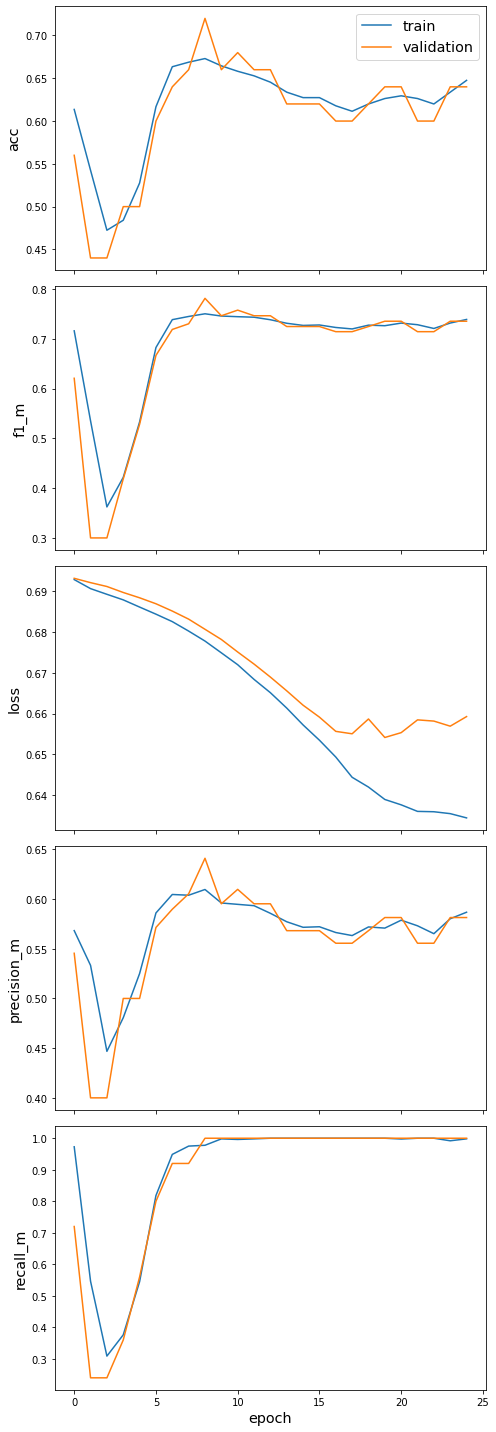

In [ ]:
sg.utils.plot_history(history)

Evaluate the trained model on test metric-issue links:

In [ ]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 134ms/step - loss: 0.6541 - acc: 0.6400 - f1_m: 0.7353 - precision_m: 0.5814 - recall_m: 1.0000
Test Evaluation:
	loss: 0.6541
	acc: 0.6400
	f1_m: 0.7353
	precision_m: 0.5814
	recall_m: 1.0000


In [ ]:
# model.save(os.path.join(PATH, "models", "linker02"))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TOM/models/linker02/assets


## Train model

Create the Keras model, and compile it by specifying the optimizer, loss function to optimise, and metrics for diagnostics:

In [273]:
import tensorflow.keras.backend as K
import tensorflow as tf

def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


shift = 2
def custom_metric(y_true,y_pred):
    diff = K.abs(K.argmax(y_true, axis=-1) - K.argmax(y_pred, axis=-1))
    return K.mean(K.lesser_equal(diff, shift))
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(), #(lr=1e-6), # lr=1e-2
    #loss=losses.mean_squared_error,
    loss = losses.binary_crossentropy, 
  #  metrics= [tf.keras.metrics.Accuracy()] #[root_mean_square_error], #, metrics.mae],
   # matrics = [custom_metric],
    metrics = ["acc", f1_m, precision_m, recall_m] 
)

Summary of the model:

In [274]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 8, 50)]      0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 8, 20)]      0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 1, 20)]      0           []                               
                                                                                                  
 reshape_15 (Reshape)           (None, 1, 8, 50)     0           ['input_15[0][0]']               
                                                                                            

In [275]:
# Specify the number of workers to use for model training
num_workers = 4

Evaluate the fresh (untrained) model on the test set (for reference):

In [276]:
test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 1s 731ms/step - loss: 0.6940 - acc: 0.4800 - f1_m: 0.3500 - precision_m: 0.4667 - recall_m: 0.2800
Untrained model's Test Evaluation:
	loss: 0.6940
	acc: 0.4800
	f1_m: 0.3500
	precision_m: 0.4667
	recall_m: 0.2800


Train the model by feeding the data from the graph in minibatches, using mapper_train, and get validation metrics after each epoch:

In [277]:
# [32, 32] layer size
es = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", mode ='min', patience = 5, restore_best_weights = True) 
epochs = 100
# To seed the random weights
seed = 0
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    callbacks = [es],
   # workers = -1,
)

Epoch 1/100
5/5 [==============================] - 2s 55ms/step - loss: 0.7059 - acc: 0.4327 - f1_m: 0.3369 - precision_m: 0.4092 - recall_m: 0.2890 - val_loss: 0.6901 - val_acc: 0.4900 - val_f1_m: 0.3704 - val_precision_m: 0.4839 - val_recall_m: 0.3000
Epoch 2/100
5/5 [==============================] - 0s 32ms/step - loss: 0.7021 - acc: 0.4339 - f1_m: 0.3417 - precision_m: 0.4109 - recall_m: 0.2935 - val_loss: 0.6878 - val_acc: 0.5000 - val_f1_m: 0.3902 - val_precision_m: 0.5000 - val_recall_m: 0.3200
Epoch 3/100
5/5 [==============================] - 0s 35ms/step - loss: 0.6994 - acc: 0.4428 - f1_m: 0.3517 - precision_m: 0.4226 - recall_m: 0.3024 - val_loss: 0.6861 - val_acc: 0.5100 - val_f1_m: 0.4235 - val_precision_m: 0.5143 - val_recall_m: 0.3600
Epoch 4/100
5/5 [==============================] - 0s 33ms/step - loss: 0.6976 - acc: 0.4395 - f1_m: 0.3600 - precision_m: 0.4193 - recall_m: 0.3171 - val_loss: 0.6847 - val_acc: 0.5200 - val_f1_m: 0.4419 - val_precision_m: 0.5278 - val_r

Plot the training history:

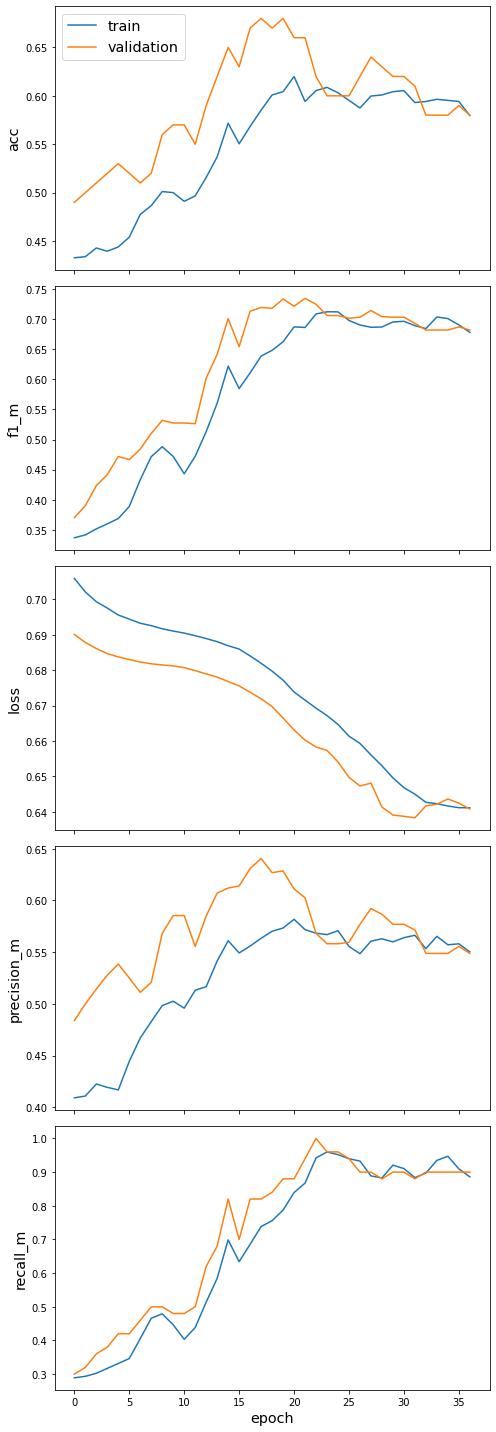

In [278]:
sg.utils.plot_history(history)

Evaluate the trained model on test metric-issue links:

In [279]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 139ms/step - loss: 0.6383 - acc: 0.6100 - f1_m: 0.6929 - precision_m: 0.5714 - recall_m: 0.8800
Test Evaluation:
	loss: 0.6383
	acc: 0.6100
	f1_m: 0.6929
	precision_m: 0.5714
	recall_m: 0.8800


In [ ]:
# model.save(os.path.join(PATH, "models", "linker02"))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/TOM/models/linker02/assets


## Load model

In [112]:
import tensorflow as tf

import tensorflow.keras.backend as K
import tensorflow as tf

def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


shift = 2
def custom_metric(y_true,y_pred):
    diff = K.abs(K.argmax(y_true, axis=-1) - K.argmax(y_pred, axis=-1))
    return K.mean(K.lesser_equal(diff, shift))
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model = tf.keras.models.load_model(os.path.join(PATH, "models", "linker02"), custom_objects={"f1_m":f1_m, "precision_m":precision_m, "recall_m": recall_m})

In [113]:
# tt = G.to_networkx()
# nx.write_gpickle(tt, path = os.path.join(PATH, "models", "graphLinker02"))

In [114]:
import networkx  as nx
tt = nx.read_gpickle(os.path.join(PATH, "models", "graphLinker02"))

In [115]:
# print(StellarGraph.from_networkx(tt).info())
# tt = StellarGraph.from_networkx(tt)
# tt.info()

In [116]:
tt

In [117]:
G

# Visualization

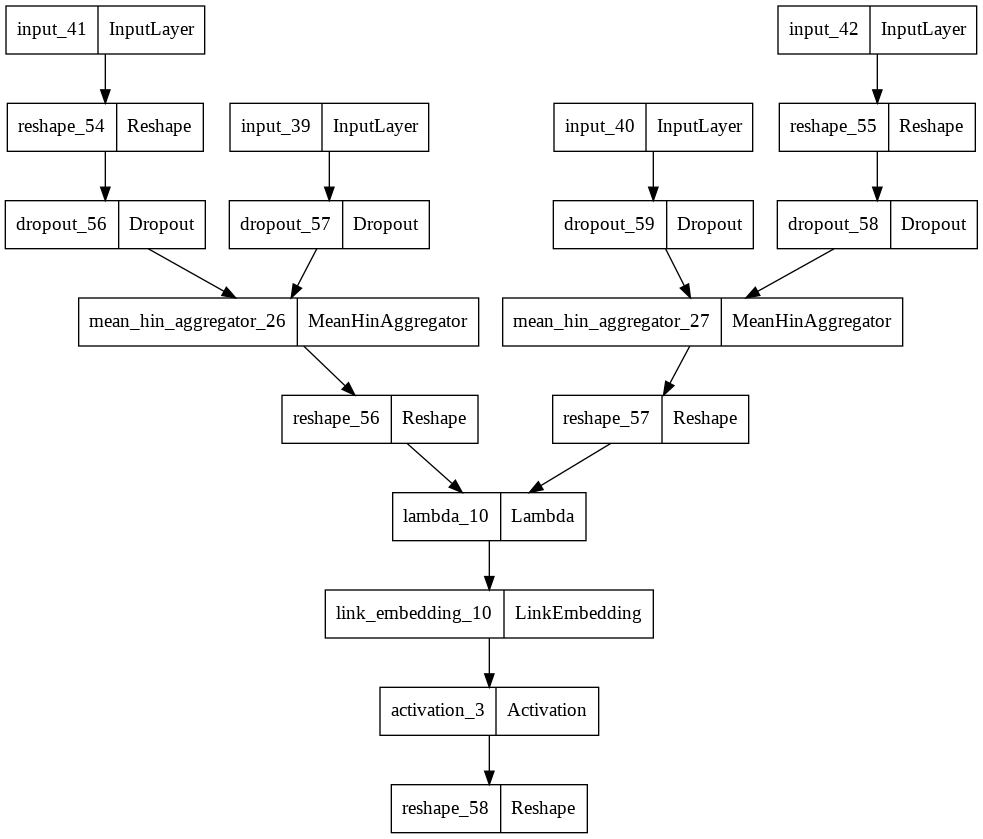

In [136]:
from keras.utils.vis_utils import plot_model


plot_model(model)

In [ ]:
Counter(graph_df.commit_topic), Counter(graph_df.issue_topic)

(Counter({0: 12,
          1: 11,
          2: 15,
          3: 13,
          4: 10,
          5: 5,
          6: 8,
          7: 18,
          8: 15,
          9: 3,
          10: 11,
          11: 5,
          12: 2,
          13: 9,
          14: 6,
          15: 9,
          16: 11,
          17: 17,
          18: 8,
          19: 21,
          20: 6,
          21: 7,
          22: 18,
          23: 11,
          24: 6,
          25: 10,
          26: 27,
          27: 21,
          28: 22,
          29: 121,
          30: 19,
          31: 24}),
 Counter({0: 5,
          1: 17,
          2: 5,
          3: 13,
          5: 7,
          6: 1,
          7: 6,
          8: 1,
          9: 4,
          10: 5,
          11: 8,
          12: 1,
          13: 1,
          14: 3,
          15: 2,
          17: 3,
          18: 30,
          19: 5,
          20: 2,
          21: 9,
          22: 3,
          23: 6,
          24: 2,
          25: 8,
          27: 4,
          28: 1,
       

In [ ]:
graph_df[['issue_topic', 'commit_topic']].values

array([[27,  5],
       [37, 26],
       [43,  8],
       ...,
       [34,  2],
       [11, 27],
       [39, 29]])

In [ ]:
# list(range(64))

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def disp_graph():
  B = nx.Graph()

  subset_color = ["red", "green"]

  # B.add_nodes_from(list(issues_nodes.index.unique()), bipartite=0)
  # B.add_nodes_from(list(commits_nodes.index.unique()), bipartite=1)
  B.add_nodes_from(map(lambda x : "issue-" + str(x), list(range(64))), bipartite=0)
  B.add_nodes_from(map(lambda x : "commit-" + str(x), list(range(32))), bipartite=1)
  # B.add_edges_from(edges.values)
  issues_top = graph_df.issue_topic.apply(lambda x: "issue-"+str(x))
  commits_top = graph_df.commit_topic.apply(lambda x: "commit-"+str(x))
  # print(issues_top)
  B.add_edges_from(pd.DataFrame({"source":issues_top.values, "target": commits_top.values}).values)
  # B.add_edges_from(graph_df[['issue_topic', 'commit_topic']].values)
  color = [subset_color[d] for v,d in B.nodes(data='bipartite')]

  plt.figure(figsize=(100, 100))
  
  # nx.draw_networkx(B, pos = nx.drawing.layout.bipartite_layout(B, list(issues_nodes.index.unique())), with_labels = False, node_size=10, node_color = color)
  nx.draw_networkx(B, pos = nx.drawing.layout.bipartite_layout(B, map(lambda x : "issue-" + str(x), list(range(64)))), node_size=4000, node_color = color)
  plt.savefig("Graph.svg", format="SVG", bbox_inches = 'tight')
# 
  # plt.show()

  return color, B



color, B = disp_graph()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# set(B.nodes)

In [ ]:
from networkx.algorithms import bipartite
bipartite.density(B, list(B.nodes)[65:]), bipartite.density(B, list(B.nodes)[:64])

(0.1488833746898263, 0.146484375)

In [ ]:
# nx.is_connected(B)
bipartite.is_bipartite(B)

True

In [ ]:
len(B.edges)
print(G.info())

# 501/(64*32)

StellarGraph: Undirected multigraph
 Nodes: 992, Edges: 501

 Node types:
  issue: [498]
    Features: float32 vector, length 50
    Edge types: issue-fixed->commit
  commit: [494]
    Features: float32 vector, length 20
    Edge types: commit-fixed->issue

 Edge types:
    commit-fixed->issue: [501]
        Weights: all 1 (default)
        Features: none


In [ ]:
density = len(G.edges())/(len(G.nodes("issue"))*len(G.nodes("commit")))
print(round(density, 5))

density = len(B.edges())/(len(B.nodes("issue"))*len(B.nodes("commit")))
print(round(density, 5))
len(B.edges())

0.00204
0.03255


300

In [ ]:
top_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes = set(B) - top_nodes
print(round(bipartite.density(B, top_nodes), 4))

# print(bipartite.spectral_bipartivity(B))
# print(bipartite.maximum_matching(B))

0.1465


In [ ]:
list(B.nodes)[:64]

['issue-0',
 'issue-1',
 'issue-2',
 'issue-3',
 'issue-4',
 'issue-5',
 'issue-6',
 'issue-7',
 'issue-8',
 'issue-9',
 'issue-10',
 'issue-11',
 'issue-12',
 'issue-13',
 'issue-14',
 'issue-15',
 'issue-16',
 'issue-17',
 'issue-18',
 'issue-19',
 'issue-20',
 'issue-21',
 'issue-22',
 'issue-23',
 'issue-24',
 'issue-25',
 'issue-26',
 'issue-27',
 'issue-28',
 'issue-29',
 'issue-30',
 'issue-31',
 'issue-32',
 'issue-33',
 'issue-34',
 'issue-35',
 'issue-36',
 'issue-37',
 'issue-38',
 'issue-39',
 'issue-40',
 'issue-41',
 'issue-42',
 'issue-43',
 'issue-44',
 'issue-45',
 'issue-46',
 'issue-47',
 'issue-48',
 'issue-49',
 'issue-50',
 'issue-51',
 'issue-52',
 'issue-53',
 'issue-54',
 'issue-55',
 'issue-56',
 'issue-57',
 'issue-58',
 'issue-59',
 'issue-60',
 'issue-61',
 'issue-62',
 'issue-63']

# Prediction

In [146]:
# generator.multiplicity

In [408]:
from numpy.ma.core import less_equal
def precision_k(actual, predicted, k):
    if len(actual)==len(predicted)==0:
      return 1

    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    return result

def recall_k(actual, predicted, k):
  if len(actual)==len(predicted)==0:
    return 1

  act_set = set(actual)
  pred_set = set(predicted[:k])
  result = len(act_set & pred_set) / float(len(act_set))
  return result

import numpy as np

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    print(predicted)
    print(actual)
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
            # score = num_hits
            print(p, " is Relevant")
            # score = num_hits
        else:
            print(p, " Not Relevant")

    if len(actual)==len(predicted)==0:
      return 1.0
    elif len(actual)==0 and len(predicted)>0:
      return 0.0
    elif len(actual)>0 and len(predicted)==0:
      return 0.0
    # print(k)
    # print(score)

    return score/min(len(actual), k)
    # return score / min(len(actual), k)

def ark(actual, predicted, k=10):
    """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    print(predicted)
    print(actual)
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / len(actual)
            print(p, " is Relevant")
            # score = num_hits
        else:
            print(p, " Not Relevant")

    if len(actual)==len(predicted)==0:
      return 1.0
    elif len(actual)==0 and len(predicted)>0:
      return 0.0
    elif len(actual)>0 and len(predicted)==0:
      return 0.0

    # print(k)
    # print(score)
    return score/min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def mark(actual, predicted, k=10):
    """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
    return np.mean([ark(a,p,k) for a,p in zip(actual, predicted)])



def predict_link1(selected_issue, issues_nodes = issues_nodes, generator = generator, model = model): #, with_evaluation = False, labels = None):
  
  generator = HinSAGELinkGenerator(G, batch_size, num_samples, head_node_types = ['commit', 'issue'])
  # generator = test_generator

  # 
  selected_issue = graph_df.set_index("issue_topic").loc[selected_issue].issue_url
  # if not isinstance(selected_issue, str) and len(selected_issue)>0:
  selected_issue = selected_issue.iloc[0]

  try:
    nodes2 = commits_nodes.index
    nodes2n = len(nodes2)
    nodes1 = [selected_issue] * nodes2n
    ex = np.array(list(zip(nodes1, nodes2)))
    ggen = generator.flow(ex)
  except:
    nodes2 = commits_nodes.index
    nodes2n = len(nodes2)
    nodes1 = [selected_issue] * nodes2n
    ex = np.array(list(zip(nodes2, nodes1)))
    # print(ex)
    ggen = generator.flow(ex)
    # print("here")
  

  # print(ggen)
  # print("Before")
  ps = model.predict(ggen)
  # print("After")

  # if with_evaluation and labels:
  #   pss = ps > 0.5
  #   print(classification_report(ps, labels))

  return ps



def predict_issue(selected_issue, k = 10, threshold = 0.5):

# selected_repo = metrics_nodes.index[1]
  ps = predict_link1(selected_issue)

  ps = ps[ ps > 0.5 ]

  selected = np.argsort(ps)[::-1] #[-50:].T
  # print(selected.min(), selected.max())
  predicted_topics = graph_df.iloc[selected].commit_topic.unique()
  selected_issue_topic = selected_issue
  # true_topics = graph_df.set_index("issue_topic").loc[selected_issue_topic].commit_topic
  # if isinstance(true_topics, collections.Iterator) and len(true_topics)>0:
  true_topics = graph_df.set_index("issue_topic").loc[selected_issue_topic].commit_topic.unique()
  # else:
  #   true_topics = [true_topics]
  # print(true_topics)
  rc = ark(true_topics, predicted_topics, k)
  pr = apk(true_topics, predicted_topics, k)

  # print(mapk(list(map(lambda x : [x], list(true_topics))), list(map(lambda x : [x], list(predicted_topics))), 5))
  return pr, rc

In [393]:

# To seed the random weights
seed = 0
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)

outputs = {}
repos = [232, 766, 476, 410]

for i in range(10):
# for i in repos:
  issue = 42 #issues_nodes.index[i]
  # print(issue)
  output = predict_issue(issue, k = 2)
  # if i_labels[repo] == 1 and output[0]>0 and output[1]>0:
  outputs[issue] = output
  print("issue : ", issue)
  print(output)
  print()
  break

# prs = []
# rcs = []
# for repo in tqdm(metrics_nodes.index):
#   pr, rc = predict_repo(metrics_nodes.index[2])
#   prs.append(pr)
#   rcs.append(rc)[np.newaxis, :]

# np.mean(prs), np.mean(rcs)

[29 17]
[28 25  0 17 29  6 26 19  7 31 30 22  4 24 20 16  8 10  3 27 23  1  2 21
 18 13 15]
29  is Relevant
17  is Relevant
[29 17]
[28 25  0 17 29  6 26 19  7 31 30 22  4 24 20 16  8 10  3 27 23  1  2 21
 18 13 15]
29  is Relevant
17  is Relevant
issue :  42
(1.0, 0.05555555555555555)



In [411]:

# To seed the random weights
seed = 0
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)
import collections

outputs = {}
isss = [42, 56, 35, 43, 44]
isss = [57, 42, 43, 61, 18]
isss = [44, 57, 46, 37, 23]


for i in range(64):
# for i in isss:
  issue = i
  # issue = 44 #issues_nodes.index[i]
  # print(issue)
  if issue == 4 : 
    continue
  try:
    output = predict_issue(issue, k = 10)
  except:
    continue
  # if i_labels[repo] == 1 and output[0]>0 and output[1]>0:
  outputs[issue] = output
  print("issue : ", issue)
  print(output)
  print()
  # break

# prs = []
# rcs = []
# for repo in tqdm(metrics_nodes.index):
#   pr, rc = predict_repo(metrics_nodes.index[2])
#   prs.append(pr)
#   rcs.append(rc)[np.newaxis, :]

# np.mean(prs), np.mean(rcs)
# np.mean(outputs.)
odf = pd.DataFrame(outputs).T.rename(columns = {0:"Pr", 1: "Rc"})

[29 31 22 30  0 21 16 20 10 17]
[29  2 17]
29  is Relevant
31  Not Relevant
22  Not Relevant
30  Not Relevant
0  Not Relevant
21  Not Relevant
16  Not Relevant
20  Not Relevant
10  Not Relevant
17  is Relevant
[29 31 22 30  0 21 16 20 10 17]
[29  2 17]
29  is Relevant
31  Not Relevant
22  Not Relevant
30  Not Relevant
0  Not Relevant
21  Not Relevant
16  Not Relevant
20  Not Relevant
10  Not Relevant
17  is Relevant
issue :  0
(0.39999999999999997, 0.3333333333333333)

[29 28 27 31 26  4  7  1  0 16]
[18 29 16 14  2  3 26]
29  is Relevant
28  Not Relevant
27  Not Relevant
31  Not Relevant
26  is Relevant
4  Not Relevant
7  Not Relevant
1  Not Relevant
0  Not Relevant
16  is Relevant
[29 28 27 31 26  4  7  1  0 16]
[18 29 16 14  2  3 26]
29  is Relevant
28  Not Relevant
27  Not Relevant
31  Not Relevant
26  is Relevant
4  Not Relevant
7  Not Relevant
1  Not Relevant
0  Not Relevant
16  is Relevant
issue :  1
(0.24285714285714285, 0.12244897959183673)

[31 29 21 30  0 22 16 20 10 17]
[29

In [412]:
odf.mean()

Pr    0.260838
Rc    0.220646
dtype: float64

In [127]:
graph_df

,commit_url,issue_url,message,commit_topic,issue_topic,issue_body,issue_title,commit_topic_words,issue_topic_words
0,https://api.github.com/repos/web3p/ethereum-tx...,https://api.github.com/repos/web3p/ethereum-tx...,Fix #41: hash didn't return transaction hash,5,27,"""Hello and thanks for developing this library....","""Transaction(EIP1559Transaction) hash doesn't ...","[return, object, address, maximum, superus, pa...","[go, transaction, git, github, com, mod, sdk, ..."
1,https://api.github.com/repos/web3p/ethereum-tx...,https://api.github.com/repos/web3p/ethereum-tx...,"Fix #15\nChange\n* Change nonce, gas, gasLimit...",26,37,"""```\r\ntxFields: Array\r\n(\r\n [nonce] =>...","""The 0x00 nonce error""","[check, code, error, miss, null, output, warn,...","[php, woocommerce, wp, plugins, index, data, c..."
2,https://api.github.com/repos/0xPrateek/Stardox...,https://api.github.com/repos/0xPrateek/Stardox...,Adding Email only feature fix #19\n\nAdded ema...,8,43,"""An `--email only` flag is required as it's re...","""Adding an --email only flag to stardox""","[display, format, featur, onli, version, initi...","[this, set, value, result, using, only, name, ..."
3,https://api.github.com/repos/0xPrateek/Stardox...,https://api.github.com/repos/0xPrateek/Stardox...,Fixed #23 - getting numbers wrong [1/2]\n\n- F...,28,42,"""Using this for the first time and it seems to...","""getting numbers wrong""","[bug, get, fail, charact, incorrect, window, w...","[this, issue, work, problem, working, any, lik..."
4,https://api.github.com/repos/notanumber/xapian...,https://api.github.com/repos/notanumber/xapian...,Fixed #49 - Improves support for exact matches...,25,42,"""For instance, given a valid search like so: \...","""__in filter combined with punctuation drops v...","[messag, improv, client, text, bodi, state, ge...","[this, issue, work, problem, working, any, lik..."
...,...,...,...,...,...,...,...,...,...
496,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...,fix #18 reset button was disabled\n\nooh this ...,9,50,"""Device: tbeam\r\nFirmware version: 1.0.0 and ...","""Device crashes when interfaced with via pytho...","[debug, prefer, root, asdf, wifi_ssid, button,...","[meshtastic, serial, debug, gpio, arduino, set..."
497,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...,"1.0.5 fix #14, let users set bool,float or str...",12,50,"""If anything other than an integer is passed t...","""--setpref requires the property and value to ...","[setstr, meshtast, run, configur, wifi, mywifi...","[meshtastic, serial, debug, gpio, arduino, set..."
498,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...,"fix #12 ""meshtastic --sendtext fish --dest '!2...",2,34,"""When using the command line:\r\nmeshtastic --...","""Destination node id format : \u2018dict\u2019...","[resolv, issu, thi, work, delet, report, excep...","[table, mysql, id, db, data, database, backup,..."
499,https://api.github.com/repos/meshtastic/Meshta...,https://api.github.com/repos/meshtastic/Meshta...,Fix #7: Properly decode OPAQUE binary packets....,27,11,"""Hi,\r\n\r\nWhen sending data in the form `int...","""\""meshtastic.receive.data\"" throws KeyError i...","[properli, valu, valid, select, disabl, detect...","[file, line, py, lib, self, package, site, loc..."


In [126]:
issues_nodes.index
# edges.source.iloc[0]

Index(['https://api.github.com/repos/web3p/ethereum-tx/issues/41',
       'https://api.github.com/repos/web3p/ethereum-tx/issues/15',
       'https://api.github.com/repos/0xPrateek/Stardox/issues/19',
       'https://api.github.com/repos/0xPrateek/Stardox/issues/23',
       'https://api.github.com/repos/notanumber/xapian-haystack/issues/49',
       'https://api.github.com/repos/notanumber/xapian-haystack/issues/119',
       'https://api.github.com/repos/notanumber/xapian-haystack/issues/109',
       'https://api.github.com/repos/notanumber/xapian-haystack/issues/101',
       'https://api.github.com/repos/notanumber/xapian-haystack/issues/98',
       'https://api.github.com/repos/notanumber/xapian-haystack/issues/111',
       ...
       'https://api.github.com/repos/meshtastic/Meshtastic-python/issues/19',
       'https://api.github.com/repos/meshtastic/Meshtastic-python/issues/27',
       'https://api.github.com/repos/meshtastic/Meshtastic-python/issues/26',
       'https://api.github.